In [1]:
import numpy as np
import pandas as pd

import keras
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

import matplotlib.pyplot as plt
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from scipy.signal import resample
from scipy.spatial.distance import cosine
from scipy.fft import fft,fftfreq

from tqdm.notebook import tqdm

## Loading Model
model = keras.models.load_model('D:/Projects/Orpheus_ai/DataSet/model_save_logs/Saved Models/VQVAE(7K)_normalized80lowrez_5e-03recloss')
embeddings = model.quantizer.layers[-1].embeddings.numpy()


c:\Users\GP65\anaconda3\lib\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
c:\Users\GP65\anaconda3\lib\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
c:\Users\GP65\anaconda3\lib\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


ImportError: DLL load failed while importing _sosfilt: The media is write protected.

In [2]:
min_level_db = -80 
sr = 22050
hop_length = 1024
n_fft = hop_length*4

In [3]:
def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def plotter(S, normalized=True):
    if normalized:
        S = denormalize(S)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
def get_distance(enc,emb):
    similarity = tf.matmul(enc, emb)
    distances = (
        tf.reduce_sum(enc ** 2, axis=1, keepdims=True)
        + tf.reduce_sum(emb ** 2, axis=0)
        - 2 * similarity
    )
    return distances.numpy()

### Manual Sampling

In [4]:
data_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')
song_location = pd.read_csv('D:/Projects/Orpheus_ai/DataSet/main_dataframe.csv',index_col=['track_id'])

In [50]:
# selected_songs = np.array(data_paths)[[31,32,33]]
selected_songs = np.array(data_paths)[[0,12]]
original_signals, original_spectorgrams, distances = [],[],[]
for path in selected_songs:
    ## Loading songs
    name = path.split("\\")[-1].split('.')[0]
    instrumental_path = song_location.loc[int(name)]['instrumental_path']
    ori_signal, _ = librosa.load(instrumental_path)
    ori_signal = ori_signal[:sr*10]
    S = np.load(path)
    model_S = normalize(np.expand_dims(np.array([S]),axis=-1))
    
    enc_output = model.encoder(model_S)
    encodings = np.reshape(enc_output, [-1, 4])
    distance = get_distance(encodings,embeddings)

    
    original_signals.append(ori_signal)
    original_spectorgrams.append(S)
    distances.append(distance)

In [51]:
cosine(embeddings.T[np.argmin(distances[0],axis=1)].reshape(-1),embeddings.T[np.argmin(distances[1],axis=1)].reshape(-1))

0.8025724440813065

In [52]:
# cosine(embeddings.T[np.argmin(distances[0],axis=1)].reshape(-1),embeddings.T[np.argmin(distances[4],axis=1)].reshape(-1))

In [53]:
quantized.shape

(1, 32, 54, 4)

In [54]:
quantized = embeddings.T[np.argmin(sum(distances),axis=1)]
quantized = quantized.reshape(enc_output.shape)
S_hat = model.decoder(quantized)[0,:,:,0]

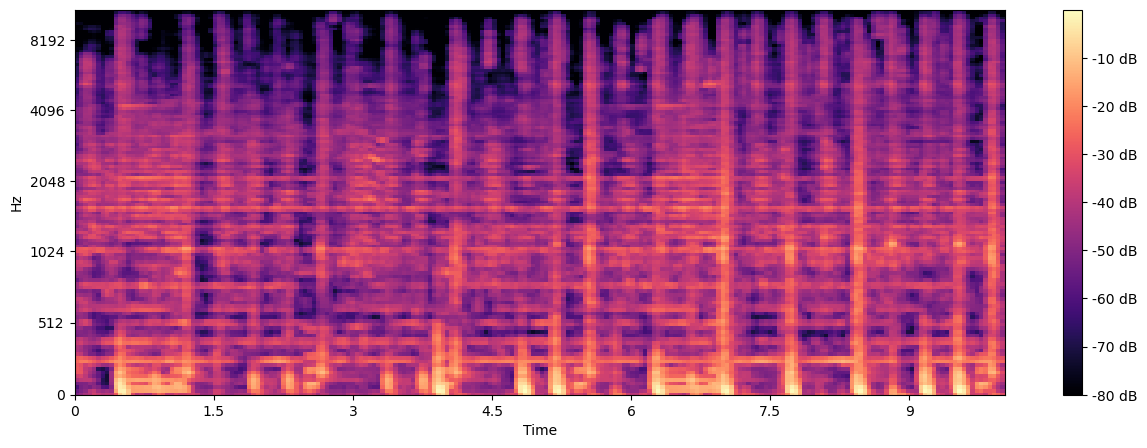

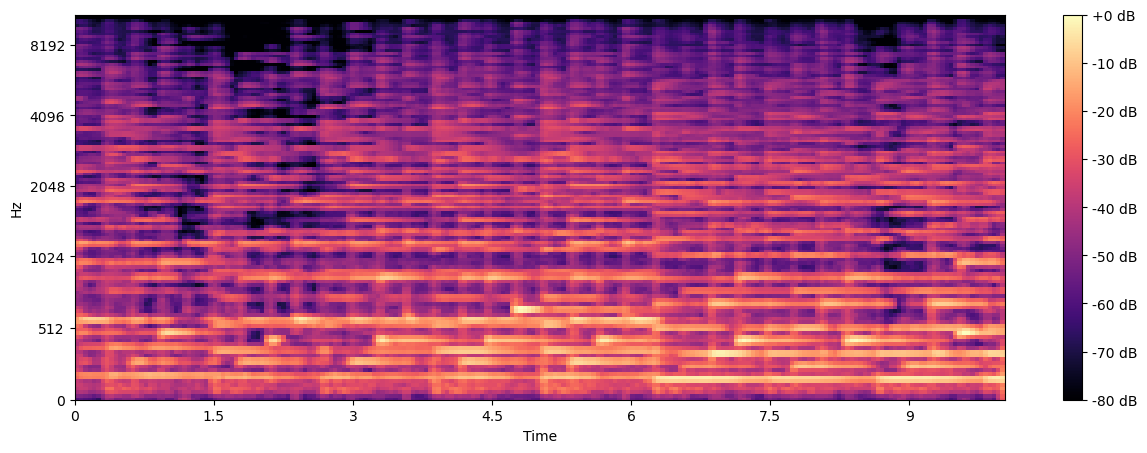

In [55]:
for i,s in enumerate(original_signals):
    plotter(original_spectorgrams[i],normalized=False)
    display(ipd.Audio(s, rate=sr))

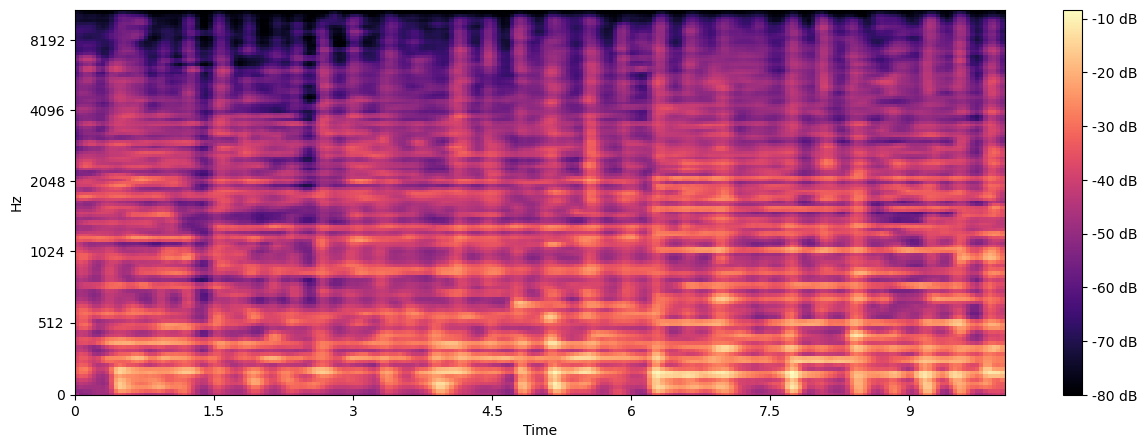

In [56]:
plotter(S_hat)
output_hat = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(denormalize(S_hat)),sr=sr,n_fft=n_fft,hop_length=hop_length)
display(ipd.Audio(output_hat, rate=sr))

In [76]:
output_hat

array([ 3.4041310e-05, -6.4837070e-05, -3.5083583e-05, ...,
       -1.0472534e-03, -1.1431180e-03, -1.1736976e-03], dtype=float32)